## Neural activity and Stimuli from Allen datasets (Extraction, Computation, and Vis)


### Libraries and Data loading

In [1]:
%load_ext autoreload

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# warnings from jupyter notebook
import warnings
warnings.filterwarnings('ignore')

%autoreload 2

In [2]:
# Install allensdk! 
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

In [3]:
import hdbscan
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
! ls -l /mnt/gs/departmentN4/AllenVisualCoding/data_boris/

total 76603281
-rwxrwx--- 1 root       departmentn4 1862261144 May 26  2020 1026123377
drwxrws--- 2 sotomayorb departmentn4       4096 Sep  7  2021 1026123377_
-rwxrwx--- 1 root       departmentn4 1859545192 May 26  2020 1026123537
drwxrws--- 2 sotomayorb departmentn4       4096 Sep  7  2021 1026123537_
-rwxrwx--- 1 root       departmentn4 2912508032 May 26  2020 1026123599
drwxrws--- 2 sotomayorb departmentn4       4096 Sep  7  2021 1026123599_
-rwxrwx--- 1 root       departmentn4 1960982972 May 26  2020 1026123651
drwxrws--- 2 sotomayorb departmentn4       4096 Sep  7  2021 1026123651_
-rwxrwx--- 1 root       departmentn4 2376304984 May 26  2020 1026123685
drwxrws--- 2 sotomayorb departmentn4       4096 Sep  7  2021 1026123685_
-rwxrwx--- 1 root       departmentn4 1736516600 May 26  2020 1026123696
drwxrws--- 2 sotomayorb departmentn4       4096 Sep  7  2021 1026123696_
-rwxrwx--- 1 root       departmentn4 2198584804 May 26  2020 1026123877
drwxrws--- 2 sotomayorb departmentn4       

In [5]:
# Load downloaded session
base_path = '/mnt/gs/departmentN4/AllenVisualCoding/data_boris/'
#base_path = '/mnt/gs/home/sotomayorb/git/AllenSDK_datasets/datasets/' # Remove this line!

sess_name = '1026124216'

session = EcephysSession.from_nwb_path('%s/%s' % (base_path, sess_name))
print ("Session loaded: `%s`" % sess_name)

Session loaded: `1026124216`


In [6]:
class DataManager:
    def __init__(self, db_path, verbose=False):
        
        if verbose:
            print ("Setting path = %s" % db_path)
        
        self.session                = None 
        self.stimulus_presentations = None
        self.neurons                = None
        
        # reading metadata in constructor
        self.meta_neuron_areas      = []
        
        # filters
        self.neurons_filter         = {} #NeuronsFilter()
        self.stimuli_filter         = {} #StimuliFilter()
    
    def read(self, verbose=False):
        self.session = EcephysSession.from_nwb_path(db_path)
        self.meta_neuron_areas = list(self.session.metadata['structure_acronyms'])
        
        if verbose:
            print ("Session loaded: `%s`" % db_path)
        
        
        # STIM filtering
        self.stimulus_presentations = self.session.stimulus_presentations
        if ('stimulus_name' in self.stimuli_filter):
            self.apply_stimuli_filter(self.stimuli_filter['stimulus_name'])
            if verbose:
                #self.stimuli_filter.summary()
                print ("self. stimulus_presentations: Finished")
        else:
            self.stimulus_presentations = self.session.stimulus_presentations
        
        # NEURON filtering
        self.neurons = self.session.units
        if 'area' in self.neurons_filter: #(type(self.neurons_filter['areas']) != type(None)):
            self.apply_neuron_filter()
            if verbose:
                self.neurons_filter.summary()
                print ("self.neurons: Finished")
        
    def set_neurons_filter(self, neuron_filter):
        if 'area' in neuron_filter:
            self.neurons_filter = neuron_filter['area']
    def set_stimuli_filter(self, stimulus_filter):
        if 'stimulus_name' in stimulus_filter: #if type(stimulus_name)!=type(None):
            self.stimuli_filter = stimulus_filter['stimulus_name']
            
    def apply_neuron_filter(self):
        self.neurons = self.session.units[self.session.units.ecephys_structure_acronym.isin(self.neurons_filter)]
    
    def apply_stimuli_filter(self):
        num_rows  = len(self.session.stimulus_presentations.stimulus_name)
        mask_name = np.zeros(shape=(num_rows), dtype = np.bool)
        for stim_name in self.stimuli_filter.stimulus_name: # for each stimulus name, we add ones to the `mask_name` variable
            mask_name |= (self.stimulus_presentations.stimulus_name == stim_name)
        self.stimulus_presentations = self.stimulus_presentations[mask_name]

In [7]:
sess_name = '1026124216'
base_path = '/mnt/pns/home/sotomayorb/git/AllenSDK_datasets/datasets' # change it !
db_path   = '%s/%s' % (base_path, sess_name)

**Reading data**

In [8]:
my_db = DataManager(db_path = db_path, verbose=True)

Setting path = /mnt/pns/home/sotomayorb/git/AllenSDK_datasets/datasets/1026124216


In [9]:
%%time
my_db.read()

CPU times: user 2min 1s, sys: 2.1 s, total: 2min 3s
Wall time: 2min 7s


**Basic data exploration**

In [10]:
my_db.session.metadata

{'specimen_name': 'Sst-IRES-Cre;Ai32-406807',
 'session_type': 'brain_observatory_1.1',
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'sex': 'M',
 'age_in_days': 96.0,
 'rig_equipment_name': 'NP.1',
 'num_units': 684,
 'num_channels': 2214,
 'num_probes': 6,
 'num_stimulus_presentations': 70390,
 'session_start_time': datetime.datetime(2018, 10, 26, 12, 59, 18, tzinfo=tzoffset(None, -25200)),
 'ecephys_session_id': 756029989,
 'structure_acronyms': [nan,
  'VPM',
  'TH',
  'LGd',
  'CA3',
  'CA2',
  'CA1',
  'VISal',
  'DG',
  'VISrl',
  'VISl',
  'VISpm',
  'LP',
  'PO',
  'Eth',
  'VISp',
  'POL',
  'APN',
  'MB',
  'SCig',
  'POST',
  'SUB',
  'VISam'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings',
  'natural_movie_three',
  'natural_movie_one',
  'static_gratings',
  'natural_scenes']}

In [11]:
[item for item in my_db.session.metadata['structure_acronyms'] if isinstance(item, str)]

['VPM',
 'TH',
 'LGd',
 'CA3',
 'CA2',
 'CA1',
 'VISal',
 'DG',
 'VISrl',
 'VISl',
 'VISpm',
 'LP',
 'PO',
 'Eth',
 'VISp',
 'POL',
 'APN',
 'MB',
 'SCig',
 'POST',
 'SUB',
 'VISam']

In [78]:
import widgets

ModuleNotFoundError: No module named 'widgets'

In [79]:
#widgets.Dropdown(
#    options=[item for item in my_db.session.metadata['structure_acronyms'] if isinstance(item, str)],
#    #value=2,
#    #description='Number:',
#)

**Neuron selection**

In [14]:
neuron_filters = {'area': ['VISp', 'VISal']} # note it can be {'area' : 'VISp'}
neuron_filters

{'area': ['VISp', 'VISal']}

In [15]:
my_db.set_neurons_filter(neuron_filters)

In [16]:
my_db.neurons_filter

['VISp', 'VISal']

In [17]:
my_db.session.stimulus_presentations

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,24.429348,null,spontaneous,84.496188,null,null,null,60.066840,0
1,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.496188,0,gabors,84.729704,4,40,30,0.233516,1
2,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.729704,0,gabors,84.979900,4,-30,10,0.250196,2
3,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.979900,0,gabors,85.230095,4,10,-10,0.250196,3
4,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.230095,0,gabors,85.480291,4,30,40,0.250196,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70385,null,null,null,null,null,"[250.0, 250.0]",null,9150.824990,14,static_gratings,9151.075201,null,null,null,0.250211,4815
70386,null,0.8,null,90,0.0,"[250.0, 250.0]",0.16,9151.075201,14,static_gratings,9151.325408,null,null,null,0.250207,4821
70387,null,null,null,null,null,"[250.0, 250.0]",null,9151.325408,14,static_gratings,9151.575614,null,null,null,0.250207,4815


In [83]:
my_db.session.stimulus_presentations[my_db.session.stimulus_presentations['stimulus_name'] == 'drifting_gratings']

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3798,null,0.8,null,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1585.734418,2,drifting_gratings,1587.736098,2,null,null,2.00168,246
3799,null,0.8,null,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1588.736891,2,drifting_gratings,1590.738571,2,null,null,2.00168,247
3800,null,0.8,null,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1591.739398,2,drifting_gratings,1593.741078,2,null,null,2.00168,246
3801,null,0.8,null,270,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1594.741921,2,drifting_gratings,1596.743591,2,null,null,2.00167,248
3802,null,0.8,null,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1597.744458,2,drifting_gratings,1599.746088,4,null,null,2.00163,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49428,null,0.8,null,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,5383.926161,7,drifting_gratings,5385.927841,4,null,null,2.00168,259
49429,null,0.8,null,0,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,5386.928658,7,drifting_gratings,5388.930338,1,null,null,2.00168,285
49430,null,0.8,null,270,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,5389.931191,7,drifting_gratings,5391.932841,15,null,null,2.00165,280


In [18]:
my_db.session.stimulus_presentations.keys()

Index(['color', 'contrast', 'frame', 'orientation', 'phase', 'size',
       'spatial_frequency', 'start_time', 'stimulus_block', 'stimulus_name',
       'stop_time', 'temporal_frequency', 'x_position', 'y_position',
       'duration', 'stimulus_condition_id'],
      dtype='object')

In [45]:
def valid_criterias_epoch_selection(dict_filter):
    if not isinstance(dict_filter, dict):
        raise TypeError("Input must be a dictionary (%s found)" % str(type(dict_filter)))
    
    dataset_column_names = list(my_db.session.stimulus_presentations.keys())
    
    # find if keys are part can be found
    for k in dict_filter.keys():
        if not k in dataset_column_names:
            raise NotImplementedError("dataset does not contain column '%s'." % k)
            
    return True

In [59]:
def get_epoch_filter_mask(dict_filter):
    mask = np.ones(shape=len(my_db.session.stimulus_presentations), dtype=np.bool)
    for k, v in dict_filter.items():
        
        if isinstance(v, list):
            temp_mask = np.zeros(shape=len(my_db.session.stimulus_presentations), dtype=np.bool)
            for item in v:
                temp_mask = temp_mask | (my_db.session.stimulus_presentations[k] == item)
            mask = mask & temp_mask
        else:
            mask = mask & (my_db.session.stimulus_presentations[k] == v)
    print (np.sum(mask))
    return np.array(mask)

In [60]:
def get_neuron_filter_mask(dict_filter):
    mask = my_db.session.units.ecephys_structure_acronym.isin(dict_filter['areas'])
    print (np.sum(mask),'out',len(mask))
    return np.array(mask)

In [63]:
get_neuron_filter_mask(dict_filter={'areas' : ['VISp']})

51 out 684


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [64]:
np.sum(my_db.session.units.ecephys_structure_acronym.isin(['VISp']))

51

In [65]:
len(my_db.session.units)

684

In [ ]:
get_neuron_filter_mask(dict_filter)

In [70]:
get_neuron_filter_mask(dict_filter={'areas' : ['VISp']})

51 out 684


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [71]:
my_db.session.units[get_neuron_filter_mask(dict_filter={'areas' : ['VISp']})]

51 out 684


,L_ratio,presence_ratio,d_prime,waveform_halfwidth,cluster_id,firing_rate,peak_channel_id,silhouette_score,waveform_repolarization_slope,waveform_amplitude,...,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951810314,6.731932e-03,0.99,3.709323,0.206030,126,7.114814,850125484,0.120317,0.229439,78.235560,...,2300,11,760640090,229,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810369,5.345009e-02,0.99,3.578593,0.206030,131,5.595007,850125488,-0.008220,0.216118,83.823675,...,2320,27,760640090,231,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810338,1.301614e-02,0.99,4.067453,0.233501,128,6.034558,850125486,0.155323,0.185828,65.479440,...,2320,59,760640090,230,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810392,1.774653e-02,0.99,3.803809,0.178559,133,1.415214,850125494,0.079454,0.287642,95.161365,...,2360,59,760640090,234,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810425,1.843604e-02,0.99,4.238960,0.164824,136,18.240085,850125500,-0.001033,0.692030,150.832890,...,2380,11,760640090,237,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951812218,3.729026e-02,0.99,2.817388,0.164824,296,3.790030,850125498,0.092064,0.219161,89.132550,...,2380,43,760640090,236,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810459,2.983152e-04,0.99,5.402746,0.096147,139,5.216888,850125502,0.159981,0.388193,126.720555,...,2400,59,760640090,238,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810548,1.392578e-02,0.99,2.110679,0.164824,145,4.499695,850125508,0.083604,0.327585,76.687650,...,2420,11,760640090,241,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810517,1.473093e-02,0.99,2.637168,0.151089,143,0.959804,850125508,0.028951,0.340594,113.447295,...,2420,11,760640090,241,385.0,probeC,See electrode locations,29999.905275,1249.996053,True


51 out 684


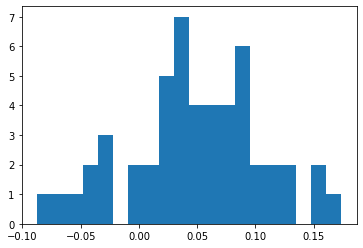

In [77]:
## IDEA: plot distributions of each neuron thingy
_ = plt.hist(my_db.session.units[get_neuron_filter_mask(dict_filter={'areas' : ['VISp']})]['silhouette_score'], bins=20)

In [66]:
my_db.session.units[my_db.session.units.ecephys_structure_acronym.isin(['VISp'])]

,L_ratio,presence_ratio,d_prime,waveform_halfwidth,cluster_id,firing_rate,peak_channel_id,silhouette_score,waveform_repolarization_slope,waveform_amplitude,...,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951810314,6.731932e-03,0.99,3.709323,0.206030,126,7.114814,850125484,0.120317,0.229439,78.235560,...,2300,11,760640090,229,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810369,5.345009e-02,0.99,3.578593,0.206030,131,5.595007,850125488,-0.008220,0.216118,83.823675,...,2320,27,760640090,231,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810338,1.301614e-02,0.99,4.067453,0.233501,128,6.034558,850125486,0.155323,0.185828,65.479440,...,2320,59,760640090,230,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810392,1.774653e-02,0.99,3.803809,0.178559,133,1.415214,850125494,0.079454,0.287642,95.161365,...,2360,59,760640090,234,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810425,1.843604e-02,0.99,4.238960,0.164824,136,18.240085,850125500,-0.001033,0.692030,150.832890,...,2380,11,760640090,237,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951812218,3.729026e-02,0.99,2.817388,0.164824,296,3.790030,850125498,0.092064,0.219161,89.132550,...,2380,43,760640090,236,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810459,2.983152e-04,0.99,5.402746,0.096147,139,5.216888,850125502,0.159981,0.388193,126.720555,...,2400,59,760640090,238,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810548,1.392578e-02,0.99,2.110679,0.164824,145,4.499695,850125508,0.083604,0.327585,76.687650,...,2420,11,760640090,241,385.0,probeC,See electrode locations,29999.905275,1249.996053,True
951810517,1.473093e-02,0.99,2.637168,0.151089,143,0.959804,850125508,0.028951,0.340594,113.447295,...,2420,11,760640090,241,385.0,probeC,See electrode locations,29999.905275,1249.996053,True


In [21]:
get_filter_mask({"temporal_frequency" : [4,8]})

3885


stimulus_presentation_id
0        False
1         True
2         True
3         True
4         True
         ...  
70385    False
70386    False
70387    False
70388    False
70389    False
Name: temporal_frequency, Length: 70390, dtype: bool

In [22]:
get_filter_mask({"stimulus_name" : "drifting_gratings"})

630


stimulus_presentation_id
0        False
1        False
2        False
3        False
4        False
         ...  
70385    False
70386    False
70387    False
70388    False
70389    False
Name: stimulus_name, Length: 70390, dtype: bool

In [23]:
get_filter_mask({'stimulus_name' : "drifting_gratings", "temporal_frequency" : [4,8]})

240


stimulus_presentation_id
0        False
1        False
2        False
3        False
4        False
         ...  
70385    False
70386    False
70387    False
70388    False
70389    False
Length: 70390, dtype: bool

In [24]:
test_mask = get_filter_mask({'stimulus_name' : "drifting_gratings", "orientation" : [0,45,90,135]})

300


In [ ]:
get_neuron_filter_mask(dict_filter)

In [25]:
my_db.session.stimulus_presentations[test_mask]

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3799,null,0.8,null,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1588.736891,2,drifting_gratings,1590.738571,2,null,null,2.00168,247
3802,null,0.8,null,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1597.744458,2,drifting_gratings,1599.746088,4,null,null,2.00163,249
3803,null,0.8,null,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1600.746921,2,drifting_gratings,1602.748601,2,null,null,2.00168,247
3806,null,0.8,null,0,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1609.754498,2,drifting_gratings,1611.756168,4,null,null,2.00167,252
3807,null,0.8,null,90,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1612.756971,2,drifting_gratings,1614.758641,2,null,null,2.00167,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,null,0.8,null,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,5356.903568,7,drifting_gratings,5358.905278,8,null,null,2.00171,284
49424,null,0.8,null,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,5371.916121,7,drifting_gratings,5373.917791,4,null,null,2.00167,259
49428,null,0.8,null,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,5383.926161,7,drifting_gratings,5385.927841,4,null,null,2.00168,259


In [26]:
type(my_db.session.spike_times)

dict

In [27]:
my_db.session.stimulus_presentations[test_mask]['orientation']

stimulus_presentation_id
3799     135
3802     135
3803     135
3806       0
3807      90
        ... 
49419     45
49424     45
49428     45
49429      0
49431    135
Name: orientation, Length: 300, dtype: object

In [28]:
def get_selected_data(stim_mask, window_length, stim_label_name):
    l_start_time = np.array(my_db.session.stimulus_presentations[stim_mask]['start_time'])
    label = np.array(my_db.session.stimulus_presentations[stim_mask][stim_label_name])
    
    index = 0
    spike_times = []; ii_spike_times = []
    for i_e in range(len(l_start_time)):
        start_time = l_start_time[i_e]
        
        temp_ii_spike_times = []
        for neuron_id, spike_train in my_db.session.spike_times.items():
            st = spike_train[(spike_train >= start_time) & (spike_train < (start_time+window_length))].copy()
            st -= start_time
            
            temp_ii_spike_times.append([index, index+len(st)])
            index += len(st)
            spike_times.append(st)
            
        ii_spike_times.append(temp_ii_spike_times)
        
    spike_times = np.concatenate(spike_times)
    ii_spike_times = np.array(ii_spike_times)
    
    return spike_times, ii_spike_times, label

In [29]:
%%time
spike_times, ii_spike_times, stim_label = get_selected_data(test_mask, window_length=1, stim_label_name='orientation')


CPU times: user 29.7 s, sys: 126 ms, total: 29.8 s
Wall time: 29.9 s


In [30]:
print ("Number of trials :", ii_spike_times.shape[0])
print ("Number of neurons:", ii_spike_times.shape[1])

Number of trials : 300
Number of neurons: 684


In [31]:
spike_times

array([0.25193535, 0.28330203, 0.61596887, ..., 0.64996225, 0.7376624 ,
       0.88992932])

In [32]:
np.min(spike_times), np.max(spike_times)

(3.4122126635338645e-07, 0.9999996597534846)

In [33]:
ii_spike_times.shape

(300, 684, 2)

---

## Data Analysis

In [34]:
sys.path.append('/mnt/pns/home/sotomayorb/git/spyke-tools-dev/')
from spyketools.proc.distances.spike_metrics import pairwise_spike_distance

In [35]:
FRz = pairwise_spike_distance(spike_times, ii_spike_times, metric='firing_rates_z')

In [36]:
%%time
VP = pairwise_spike_distance(spike_times, ii_spike_times, metric='victor_purpura', attrs={"cost" : None})

CPU times: user 15min 38s, sys: 956 ms, total: 15min 39s
Wall time: 15min 39s


In [37]:
si = np.argsort(stim_label)

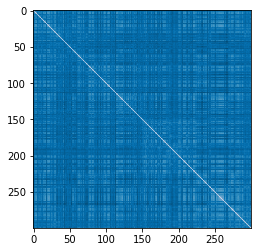

In [38]:
plt.imshow(VP[:,si][si], cmap='PuBu')

In [39]:
perplexity = 70.

In [40]:
emb_FRz    = TSNE(metric='precomputed', n_components=2, random_state=0, perplexity=perplexity).fit_transform(FRz)
emb_VP     = TSNE(metric='precomputed', n_components=2, random_state=0, perplexity=perplexity).fit_transform(VP)

In [41]:
def tsne_visualization(emb, stim_ids, fs_label=14, fn_legend=14, show_legend=False, title=""):
    fig, axs = plt.subplots(figsize=(5,5), facecolor='w')
    unique_stim_ids = np.unique(stim_ids)
    for stim_id in unique_stim_ids:
        mask = (stim_ids==stim_id)
        axs.scatter(emb[mask,0], emb[mask,1], label=stim_id)
    if show_legend:
        axs.legend(frameon=False, fontsize=fn_legend)
    if title!="":
        axs.set_title(title, fontsize=fs_label)
    axs.set_xlabel("1st component", fontsize=fs_label)
    axs.set_ylabel("2nd component", fontsize=fs_label)

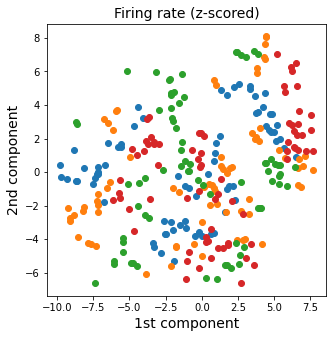

In [42]:
tsne_visualization(emb=emb_FRz, stim_ids=stim_label, fs_label=14, show_legend=False, title="Firing rate (z-scored)")

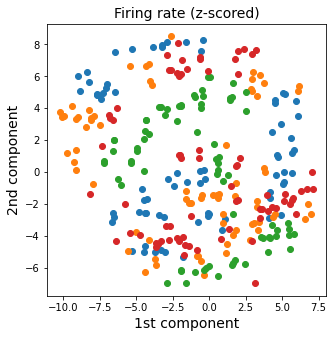

In [43]:
tsne_visualization(emb=emb_VP, stim_ids=stim_label, fs_label=14, show_legend=False, title="Firing rate (z-scored)")

## TODO 

**TODO**:
+ Dataset exploration:
    + Show basic stats (example: stimulus duration (min and max values))
+ Implement more complex filters
+ Implement a nicer way to display metadata

**Modules:**
+ Data Exploration:
    + Explore dataset based on metadata in nwb dataset
    + 

---


# Playground

In [85]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [91]:
left_column = widgets.Label(
                    value='Photo by CDC on Unsplash',
                    style={'description_width': 'initial'}
                )

right_headline = widgets.Label(
                    value='Photo by CDC on Unsplash',
                    style={'description_width': 'initial'}
                )

vbox_headline = widgets.VBox([left_column, right_headline])


grand = widgets.ToggleButtons(
            options=['grandson', 'granddaughter']
        )

name = widgets.Text(placeholder='Your name here')

# number of friends

friends = widgets.IntSlider(
            value=3, # default value
            min=0, 
            max=10,
            step=1,
            style={'description_width': 'initial', 'handle_color': '#16a085'} 
        )

# button send

button_send = widgets.Button(
                description='Send to grandma',
                tooltip='Send',
                style={'description_width': 'initial'}
            )

output = widgets.Output()

def on_button_clicked(event):
    with output:
        clear_output()
        print("Sent message: ")
        print(f"Dear Grandma! This is your favourite {grand.value}, {name.value}.")
        print(f"Also, if you don't mind, I'll bring along {friends.value} hungry ghosts for your delicious food!")

button_send.on_click(on_button_clicked)

vbox_result = widgets.VBox([button_send, output])


In [92]:
# stacked right hand side

text_0 = widgets.HTML(value="<h1>Dear Grandma!</h1>")
text_1 = widgets.HTML(value="<h2>This is your favourite</h2>")
text_2= widgets.HTML(value="<h2>I would love to come over on </h2>")
text_3= widgets.HTML(value="<h2>for dinner, if that's okay for you!</h2>")
text_4= widgets.HTML(value="<h2>Also, if you don't mind, I'll bring along </h2>")
text_5= widgets.HTML(value="<h2>hungry ghosts for dinner, if that's okay for you!</h2>")

vbox_text = widgets.VBox([text_0, text_1, grand, name, text_2, text_3, text_4, friends, text_5, vbox_result])



In [94]:
page = widgets.HBox([vbox_text])
display(page)

In [118]:
my_db.session.metadata

{'specimen_name': 'Sst-IRES-Cre;Ai32-406807',
 'session_type': 'brain_observatory_1.1',
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'sex': 'M',
 'age_in_days': 96.0,
 'rig_equipment_name': 'NP.1',
 'num_units': 684,
 'num_channels': 2214,
 'num_probes': 6,
 'num_stimulus_presentations': 70390,
 'session_start_time': datetime.datetime(2018, 10, 26, 12, 59, 18, tzinfo=tzoffset(None, -25200)),
 'ecephys_session_id': 756029989,
 'structure_acronyms': [nan,
  'VPM',
  'TH',
  'LGd',
  'CA3',
  'CA2',
  'CA1',
  'VISal',
  'DG',
  'VISrl',
  'VISl',
  'VISpm',
  'LP',
  'PO',
  'Eth',
  'VISp',
  'POL',
  'APN',
  'MB',
  'SCig',
  'POST',
  'SUB',
  'VISam'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings',
  'natural_movie_three',
  'natural_movie_one',
  'static_gratings',
  'natural_scenes']}

In [123]:
widgets.Dropdown(
    options=['FR','FRz','VP'],
    value='FR',
    description='Distance:',
    disabled=False,
)

Dropdown(description='Distance:', options=('FR', 'FRz', 'VP'), value='FR')

In [126]:
#dates = [datetime.date(2015, i, 1) for i in range(1, 13)]
options = range(1,13) #[(i.strftime('%b'), i) for i in dates]
widgets.SelectionRangeSlider(
    options=options,
    index=(0, 3),
    description='Months (2015)',
    disabled=False
)

SelectionRangeSlider(description='Months (2015)', index=(0, 3), options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

In [120]:
text_0 = widgets.HTML(value="<h3>Neuron seleccion<h3>")
text_1 = widgets.HTML(value="<h4>Brain area:<h4>")
text_2 = widgets.HTML(value="<h4>Stimulus selection:<h4>")

# selection of brain area
sel_brain_area = widgets.Select(
    options=[item for item in my_db.session.metadata['structure_acronyms'] if isinstance(item, str)],
    rows=20,
    #description='brain area:',
    disabled=False
)

sel_stimulus_names = widgets.Select(
    options=[item for item in my_db.session.metadata['stimulus_names'] if isinstance(item, str)],
    rows=20,
    #description='brain area:',
    disabled=False
)

sel_distance = widgets.Dropdown(
    options=['FR','FRz','VP'],
    value='2',
    description='Number:',
    disabled=False,
)

vbox_text = widgets.VBox([text_0, text_1, sel_brain_area, text_2, sel_stimulus_names])
page = widgets.HBox([vbox_text])
display(page)

In [128]:
accordion = widgets.Accordion(children=[sel_brain_area, sel_stimulus_names], titles=('Neuron', 'Epoch selection'))
accordion

Accordion(children=(Select(options=('VPM', 'TH', 'LGd', 'CA3', 'CA2', 'CA1', 'VISal', 'DG', 'VISrl', 'VISl', '…

In [80]:
import ipywidgets as widgets

In [97]:
widgets.Select(
    options=[item for item in my_db.session.metadata['structure_acronyms'] if isinstance(item, str)],
    #value='all',
    # rows=10,
    description='structure acronyms:',
    disabled=False
)

Select(description='structure acronyms:', options=('VPM', 'TH', 'LGd', 'CA3', 'CA2', 'CA1', 'VISal', 'DG', 'VI…

In [96]:
[item for item in my_db.session.metadata['structure_acronyms'] if isinstance(item, str)]

['VPM',
 'TH',
 'LGd',
 'CA3',
 'CA2',
 'CA1',
 'VISal',
 'DG',
 'VISrl',
 'VISl',
 'VISpm',
 'LP',
 'PO',
 'Eth',
 'VISp',
 'POL',
 'APN',
 'MB',
 'SCig',
 'POST',
 'SUB',
 'VISam']

In [119]:
#do_filter([{'stimulus_name' : "drifting_gratings", "temporal_frequency" : [4,8]}, {'stimulus_name' : "natural_scenes"}])

In [105]:
validate_filter(3)#{'stimulus_name' : "test"})

TypeError: Input must be a dictionary (<class 'int'> found)

In [109]:
validate_filter({'stimulus_name'})

TypeError: Input must be a dictionary (<class 'set'> found)

In [110]:
validate_filter({'stimulus_name' : "test"})

In [111]:
my_db.set_stimuli_filter({'stimulus_name':"drifting_gratings"})

NameError: name 'stimulus_name' is not defined

In [ ]:
my_db.stimuli_filter

In [6]:
session.units

,L_ratio,presence_ratio,d_prime,waveform_halfwidth,cluster_id,firing_rate,peak_channel_id,silhouette_score,waveform_repolarization_slope,waveform_amplitude,...,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951814884,0.024771,0.99,3.555518,0.096147,6,9.492176,850126382,0.033776,0.673650,187.434780,...,60,43,760640083,4,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
951814876,0.001785,0.99,4.445414,0.206030,5,39.100557,850126382,0.108908,0.518633,129.686505,...,60,43,760640083,4,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
951815032,0.035654,0.99,3.848256,0.096147,17,28.383277,850126398,0.096715,0.766347,207.380940,...,140,43,760640083,12,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
951815275,0.016783,0.99,3.065938,0.096147,30,5.709358,850126416,0.144249,0.628944,158.158650,...,220,11,760640083,21,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
951815314,0.009666,0.99,4.198612,0.123618,34,23.902235,850126420,0.111106,0.740222,173.475705,...,240,27,760640083,23,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951814089,0.032323,0.99,3.194123,0.192295,138,6.579819,850122942,0.046354,0.285857,101.803065,...,1560,59,760640104,154,417.0,probeF,See electrode locations,30000.023099,1250.000962,True
951814212,0.235540,0.99,2.005153,0.137353,149,8.288338,850122968,0.044749,0.248256,77.300730,...,1680,27,760640104,167,417.0,probeF,See electrode locations,30000.023099,1250.000962,True
951814199,0.001055,0.99,6.563771,0.151089,148,2.653770,850122968,0.201445,0.384777,139.877010,...,1680,27,760640104,167,417.0,probeF,See electrode locations,30000.023099,1250.000962,True


---

### Stimulus presentation

Text(0.5, 0, 'Time')

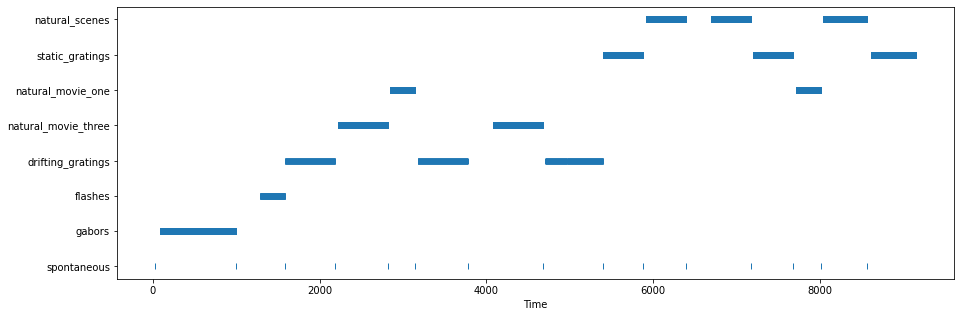

In [7]:
plt.figure(figsize=(15,5))
plt.plot(
    session.stimulus_presentations.start_time, 
    session.stimulus_presentations.stimulus_name,
    marker= '|', linestyle=''
    )

plt.xlabel("Time")

In [8]:
session.stimulus_presentations[ session.stimulus_presentations.stimulus_name == 'natural_movie_one' ]

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
22000,null,1,0,0,null,"[1920.0, 1080.0]",null,2846.788598,4,natural_movie_one,2846.821959,null,null,null,0.033361,3887
22001,null,1,1,0,null,"[1920.0, 1080.0]",null,2846.821959,4,natural_movie_one,2846.855320,null,null,null,0.033361,3888
22002,null,1,2,0,null,"[1920.0, 1080.0]",null,2846.855320,4,natural_movie_one,2846.888681,null,null,null,0.033361,3889
22003,null,1,3,0,null,"[1920.0, 1080.0]",null,2846.888681,4,natural_movie_one,2846.922042,null,null,null,0.033361,3890
22004,null,1,4,0,null,"[1920.0, 1080.0]",null,2846.922042,4,natural_movie_one,2846.955403,null,null,null,0.033361,3891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66113,null,1,895,0,null,"[1920.0, 1080.0]",null,8010.955485,12,natural_movie_one,8010.988846,null,null,null,0.033361,4782
66114,null,1,896,0,null,"[1920.0, 1080.0]",null,8010.988846,12,natural_movie_one,8011.022206,null,null,null,0.033361,4783
66115,null,1,897,0,null,"[1920.0, 1080.0]",null,8011.022206,12,natural_movie_one,8011.055567,null,null,null,0.033361,4784


In [37]:
session.stimulus_presentations.keys()

Index(['color', 'contrast', 'frame', 'orientation', 'phase', 'size',
       'spatial_frequency', 'start_time', 'stimulus_block', 'stimulus_name',
       'stop_time', 'temporal_frequency', 'x_position', 'y_position',
       'duration', 'stimulus_condition_id'],
      dtype='object')

In [ ]:
my_selection = {}

In [ ]:
stimulus_name

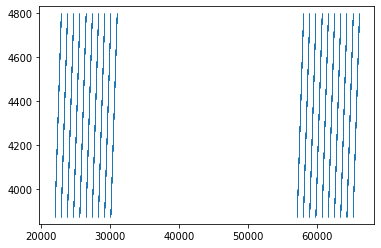

In [9]:
plt.plot(
    session.stimulus_presentations.stimulus_condition_id[ session.stimulus_presentations.stimulus_name == 'natural_movie_one' ],
    marker='|', ls=''
)

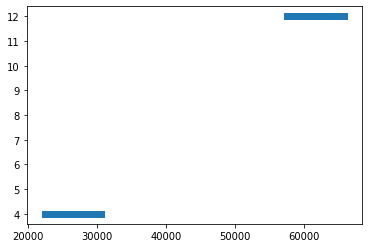

In [10]:
plt.plot(
    session.stimulus_presentations.stimulus_block[ session.stimulus_presentations.stimulus_name == 'natural_movie_one' ],
    marker='|', ls=''
)

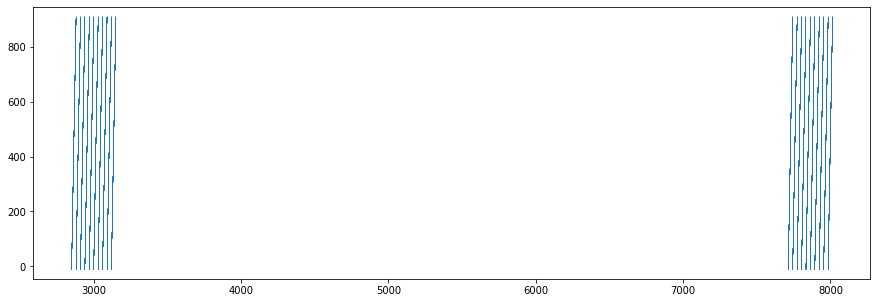

In [11]:
plt.figure(figsize=(15,5));
plt.plot(
    session.stimulus_presentations.start_time[ session.stimulus_presentations.stimulus_name == 'natural_movie_one' ],
    session.stimulus_presentations.frame[ session.stimulus_presentations.stimulus_name == 'natural_movie_one' ],
    marker='|', ls=''
)

In [12]:
NS_table = session.stimulus_presentations[
    (session.stimulus_presentations.stimulus_name == 'natural_scenes')
]

In [13]:
NS_table

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
51355,null,null,95,null,null,null,null,5909.365398,9,natural_scenes,5909.615606,null,null,null,0.250208,4908
51356,null,null,87,null,null,null,null,5909.615606,9,natural_scenes,5909.865814,null,null,null,0.250208,4909
51357,null,null,72,null,null,null,null,5909.865814,9,natural_scenes,5910.116023,null,null,null,0.250208,4910
51358,null,null,41,null,null,null,null,5910.116023,9,natural_scenes,5910.366231,null,null,null,0.250208,4911
51359,null,null,9,null,null,null,null,5910.366231,9,natural_scenes,5910.616443,null,null,null,0.250212,4912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68224,null,null,81,null,null,null,null,8567.837656,13,natural_scenes,8568.087864,null,null,null,0.250208,4927
68225,null,null,17,null,null,null,null,8568.087864,13,natural_scenes,8568.338073,null,null,null,0.250208,5011
68226,null,null,113,null,null,null,null,8568.338073,13,natural_scenes,8568.588281,null,null,null,0.250208,4944


**NWB to Numpy**

In [14]:
l_stim_start_time  = np.array(NS_table['start_time']) # Stimulus onset
l_stim_orientation = np.array(NS_table['orientation'])           # Natural Image ID
duration = 0.25 # seconds

In [16]:
#print ("Number of natural scenes         : %i" % len(set(l_stim_frame)))
#print ("Number of presentations per image: %i" % (len(l_stim_frame)/len(set(l_stim_frame))))

---

### Accessing neurons and spiketimes

In [17]:
"total neurons in this session", len(session.spike_times.keys())

('total neurons in this session', 684)

In [18]:
neurons = session.units

In [19]:
neurons

,L_ratio,presence_ratio,d_prime,waveform_halfwidth,cluster_id,firing_rate,peak_channel_id,silhouette_score,waveform_repolarization_slope,waveform_amplitude,...,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951814884,0.024771,0.99,3.555518,0.096147,6,9.492176,850126382,0.033776,0.673650,187.434780,...,60,43,760640083,4,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
951814876,0.001785,0.99,4.445414,0.206030,5,39.100557,850126382,0.108908,0.518633,129.686505,...,60,43,760640083,4,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
951815032,0.035654,0.99,3.848256,0.096147,17,28.383277,850126398,0.096715,0.766347,207.380940,...,140,43,760640083,12,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
951815275,0.016783,0.99,3.065938,0.096147,30,5.709358,850126416,0.144249,0.628944,158.158650,...,220,11,760640083,21,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
951815314,0.009666,0.99,4.198612,0.123618,34,23.902235,850126420,0.111106,0.740222,173.475705,...,240,27,760640083,23,215.0,probeA,See electrode locations,29999.949611,1249.997900,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951814089,0.032323,0.99,3.194123,0.192295,138,6.579819,850122942,0.046354,0.285857,101.803065,...,1560,59,760640104,154,417.0,probeF,See electrode locations,30000.023099,1250.000962,True
951814212,0.235540,0.99,2.005153,0.137353,149,8.288338,850122968,0.044749,0.248256,77.300730,...,1680,27,760640104,167,417.0,probeF,See electrode locations,30000.023099,1250.000962,True
951814199,0.001055,0.99,6.563771,0.151089,148,2.653770,850122968,0.201445,0.384777,139.877010,...,1680,27,760640104,167,417.0,probeF,See electrode locations,30000.023099,1250.000962,True


In [20]:
l_n_ids  = np.array(neurons.index) # list of neuron's IDs
print ("Total neurons: %s" % l_n_ids.shape[0])

Total neurons: 684


In [21]:
print ("List of properties", neurons.keys())

List of properties Index(['L_ratio', 'presence_ratio', 'd_prime', 'waveform_halfwidth',
       'cluster_id', 'firing_rate', 'peak_channel_id', 'silhouette_score',
       'waveform_repolarization_slope', 'waveform_amplitude', 'snr',
       'waveform_velocity_below', 'max_drift', 'nn_miss_rate', 'nn_hit_rate',
       'waveform_velocity_above', 'waveform_spread', 'amplitude_cutoff',
       'waveform_duration', 'waveform_PT_ratio', 'cumulative_drift',
       'isolation_distance', 'isi_violations', 'waveform_recovery_slope',
       'local_index_unit', 'anterior_posterior_ccf_coordinate',
       'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate',
       'ecephys_structure_acronym', 'probe_vertical_position',
       'probe_horizontal_position', 'probe_id', 'channel_local_index',
       'ecephys_structure_id', 'probe_description', 'location',
       'probe_sampling_rate', 'probe_lfp_sampling_rate', 'probe_has_lfp_data'],
      dtype='object')


**Spike times**

In [22]:
l_spike_times = np.array([ session.spike_times[n_id] for n_id in l_n_ids ]) #dex#[l_n_ids]

In [23]:
print("spike times:", l_spike_times)

spike times: [array([3.80928400e+00, 3.84358406e+00, 3.94235089e+00, ...,
       9.94395425e+03, 9.96080897e+03, 9.96476828e+03])
 array([3.82861736e+00, 3.87158410e+00, 3.90445082e+00, ...,
       9.96614322e+03, 9.96616348e+03, 9.96618938e+03])
 array([3.81211734e+00, 3.83468404e+00, 3.90791750e+00, ...,
       9.96618255e+03, 9.96619485e+03, 9.96620922e+03])
 array([3.87385077e+00, 3.94535089e+00, 3.97931762e+00, ...,
       9.90429721e+03, 9.91353780e+03, 9.94737115e+03])
 array([3.80601733e+00, 3.82201735e+00, 3.82865070e+00, ...,
       9.96544542e+03, 9.96545708e+03, 9.96553402e+03])
 array([3.81051733e+00, 3.82808403e+00, 3.86331742e+00, ...,
       9.95155443e+03, 9.96555178e+03, 9.96565845e+03])
 array([6.38542166e+00, 1.15116969e+01, 1.15370970e+01, ...,
       9.95688457e+03, 9.96524272e+03, 9.96548838e+03])
 array([3.80391732e+00, 3.81505067e+00, 3.83268404e+00, ...,
       9.92975532e+03, 9.95420393e+03, 9.96108484e+03])
 array([3.78548396e+00, 3.80398399e+00, 3.82135069e

In [24]:
l_n_ids

array([951814884, 951814876, 951815032, 951815275, 951815314, 951815335,
       951815517, 951815642, 951815712, 951815812, 951815886, 951815948,
       951815938, 951815929, 951815967, 951816201, 951816190, 951816180,
       951816222, 951816328, 951816336, 951818175, 951816365, 951816480,
       951816471, 951816452, 951816607, 951816565, 951816539, 951816416,
       951816826, 951816691, 951816638, 951818326, 951816775, 951816951,
       951816936, 951816988, 951817042, 951817026, 951817018, 951817177,
       951817159, 951817153, 951817227, 951817219, 951817212, 951817185,
       951817233, 951817257, 951817303, 951817350, 951817341, 951818214,
       951817332, 951817324, 951817376, 951817367, 951817489, 951817431,
       951817422, 951817396, 951817447, 951817440, 951817643, 951817514,
       951817506, 951817482, 951818241, 951817532, 951817473, 951817589,
       951817568, 951817559, 951817551, 951817634, 951817614, 951817605,
       951817597, 951817693, 951817677, 951817651, 

In [25]:
# Example of `t_start` and `t_stop` for a window length equal to 0.250sec
t_start = 0.0
t_stop  = 0.250

In [26]:
# filtering by stilumus:

n_stimulus = 20 # Replace 10 by l_stim_start_time.shape[0] (all the trials)
n_neurons  = l_n_ids.shape[0]
    
spike_times = np.array([])
ii_spike_times = np.zeros([n_stimulus,n_neurons,2], dtype=np.uint32)


for i in range(n_stimulus):
    print ("Processing epoch #%s" % (i+1))
    tmp_start_time_i = l_stim_start_time[i] + t_start
    tmp_stop_time_i  = l_stim_start_time[i] + t_stop
    
    for j in range(n_neurons):
        tmp_spike_time  = session.spike_times[neurons.index[j]]
        
        tmp_spike_time  = tmp_spike_time[
            (tmp_spike_time>=tmp_start_time_i) & (tmp_spike_time<tmp_stop_time_i)
        ]
        spike_times = np.append(spike_times,tmp_spike_time - tmp_start_time_i)
        ii_spike_times[i,j,0] = int(np.max(ii_spike_times))
        ii_spike_times[i,j,1] = int(ii_spike_times[i,j,0] + len(tmp_spike_time))

Processing epoch #1
Processing epoch #2
Processing epoch #3
Processing epoch #4
Processing epoch #5
Processing epoch #6
Processing epoch #7
Processing epoch #8
Processing epoch #9
Processing epoch #10
Processing epoch #11
Processing epoch #12
Processing epoch #13
Processing epoch #14
Processing epoch #15
Processing epoch #16
Processing epoch #17
Processing epoch #18
Processing epoch #19
Processing epoch #20


In [27]:
print ("# Epochs: %i # Neurons: %i" % (ii_spike_times.shape[0], ii_spike_times.shape[1]))

# Epochs: 20 # Neurons: 684


**Visualization by trial**

In [28]:
def raster(spike_times, ii_spike_times, epoch_id, figsize=(14,4), xrange=()):
    plt.figure(figsize=figsize)
    for n in range(ii_spike_times.shape[1]): # num neurons
        tmp_st = spike_times[ ii_spike_times[epoch_id,n,0]:ii_spike_times[epoch_id,n,1] ]
        plt.plot(tmp_st, np.ones(tmp_st.shape[0])*n, marker='|', color='black', linestyle='')
    plt.xlabel('Time [s]'); plt.ylabel('Neuron ID');
    if xrange!=():
        plt.xlim(xrange)

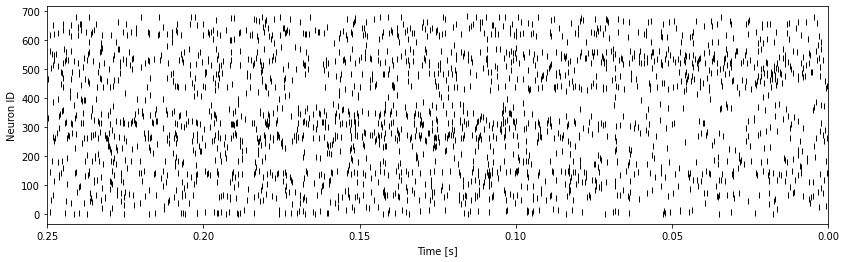

In [29]:
raster(spike_times, ii_spike_times, epoch_id = 0, xrange=(t_stop, t_start))

**Spike Count (SC)**

In [30]:
def get_spike_count_per_epoch(spike_times, ii_spike_times, normalized=''):
    '''
    Spike Count per trial (Raw SC). 
    If `normalized` is equal to 'zscore', it return the z-scored spike counts.
    '''
    spike_count_per_epoch = np.zeros((ii_spike_times.shape[0], ii_spike_times.shape[1]), dtype=np.float32)
    for i_e in range(ii_spike_times.shape[0]):
        for i_n in range(ii_spike_times.shape[1]):#n_selected_neurons):
            tmp_spks = spike_times[ii_spike_times[i_e,i_n,0]:ii_spike_times[i_e,i_n,1]]
            spike_count_per_epoch[i_e, i_n] = len(tmp_spks)
        
    if normalized=='zscore':
        for i_n in range(ii_spike_times.shape[1]):
            if np.std(spike_count_per_epoch[:, i_n])>0:
                spike_count_per_epoch[:, i_n] = (spike_count_per_epoch[:, i_n] - np.mean(spike_count_per_epoch[:, i_n])) / np.std(spike_count_per_epoch[:, i_n])
            
    return spike_count_per_epoch

In [31]:
def euclidean_dist(st1, st2):
    '''
    Euclidean distance between two spike trains `st1` and `st2`.
    '''
    ret = 0.
    for ii in range(len(st1)):
        ret += (st1[ii]-st2[ii])**2 # sum
    
    return np.sqrt(ret)

def diss_spike_counts(SC):
    '''
    Dissimilarity Matrix between spike count vectors via Euclidean distance.
    '''
    diss_spike_count = np.zeros((SC.shape[0], SC.shape[0]))
    for i_e1 in range(SC.shape[0]):
        for i_e2 in range(i_e1, SC.shape[0]):
            diss_spike_count[i_e1, i_e2] = euclidean_dist(SC[i_e1], SC[i_e2])
            diss_spike_count[i_e2, i_e1] = diss_spike_count[i_e1, i_e2]
    return diss_spike_count

In [32]:
# let's compute spike count per trial
SC = get_spike_count_per_epoch(spike_times, ii_spike_times)

In [34]:
# Computing dissimilarity matrix (Euclidean distance of Spike count vectors)
dissimilarities = diss_spike_counts(SC)

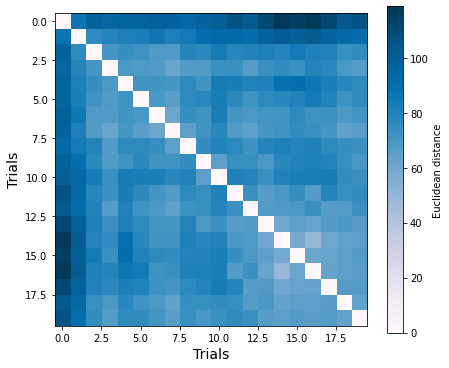

In [35]:
fs = 14 # fontsize
plt.figure(figsize=(7,6))
plt.imshow(dissimilarities, cmap='PuBu'); plt.xlabel('Trials',fontsize=fs); plt.ylabel('Trials',fontsize=fs)
_ = plt.colorbar(label='Euclidean distance')

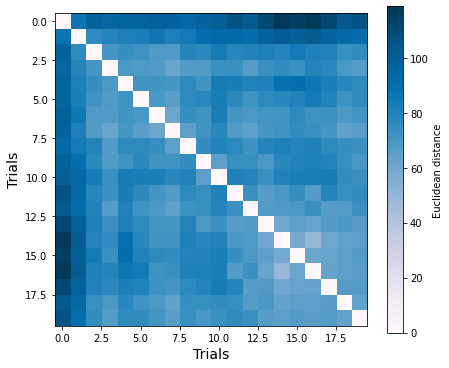

In [36]:
fs = 14 # fontsize
plt.figure(figsize=(7,6))
plt.imshow(dissimilarities, cmap='PuBu'); plt.xlabel('Trials',fontsize=fs); plt.ylabel('Trials',fontsize=fs)
_ = plt.colorbar(label='Euclidean distance')

## TODO:
